# covert from voc to coco

https://github.com/umitron/umitron-fish-detection/blob/develop/doc/train_data_format.md

In [3]:
!ls ../data/annotations/

1816700b-8029-415d-b28d-4a4f3d31f1fb.xml
189e856f-95ef-4684-b13f-64247168994b.xml
2cf3324f-5730-400c-92b9-c4354a522f53.xml
2ee6409a-53d5-49aa-a086-df1d65e204b5.xml
335c1a6d-6564-40a7-83a1-294e63976a06.xml
34b595e1-2c52-4335-a605-e58c641a6b83.xml
40b108cb-ecca-4641-bd21-ef3bbf37ba2e.xml
420168f8-cac2-4f97-b096-ca47f5c0972e.xml
4331961b-d060-4dc6-8afd-bdee7d41d700.xml
577428a0-052f-409b-8c00-056fa547167e.xml
68306358-a039-428b-a0c9-c40a6ee95c49.xml
6aebadd7-382b-4791-badf-444a7163f103.xml
71817848-a3a8-46c3-982e-cb85fceab6de.xml
74bd26ef-afb7-4e6b-9fa0-4e872f4b6200.xml
770ff828-fdae-448c-999c-614865cc7772.xml
92db25f2-b245-4564-a20e-2d94e7c0087d.xml
941f6490-0843-4bda-a99f-a976343c945f.xml
9af56351-0c6a-46e1-bf8b-0ba9c57b1fc3.xml
a3608c2a-e1c0-48b4-9b52-5f1ece84f917.xml
bd0b22b3-55de-41ec-ad45-c7d4dcae54f7.xml
c0d8de87-e610-4705-b075-434577c5a2c5.xml
cc083026-85b4-4c5a-bae6-94b6339a9532.xml
d7a659ef-847d-476a-9a81-fa1b088a50c0.xml
e387a337-7d69-4aa7-8113-8d1d7122d0d6.xml
instances_yellow

# overview data

In [4]:
import xmltodict

In [5]:
xml_file = "../data/annotations/1816700b-8029-415d-b28d-4a4f3d31f1fb.xml"

In [6]:
ann = xmltodict.parse(open(xml_file, 'r').read())['annotation']

In [7]:
ann

OrderedDict([(u'folder', u'images'),
             (u'filename', u'1816700b-8029-415d-b28d-4a4f3d31f1fb.png'),
             (u'path',
              u'/Users/makoto_sato/umitron-fish-detection/data/images/1816700b-8029-415d-b28d-4a4f3d31f1fb.png'),
             (u'source', OrderedDict([(u'database', u'Unknown')])),
             (u'size',
              OrderedDict([(u'width', u'1280'),
                           (u'height', u'480'),
                           (u'depth', u'3')])),
             (u'segmented', u'0'),
             (u'object',
              [OrderedDict([(u'name', u'yellowtail'),
                            (u'pose', u'Unspecified'),
                            (u'truncated', u'0'),
                            (u'difficult', u'0'),
                            (u'bndbox',
                             OrderedDict([(u'xmin', u'121'),
                                          (u'ymin', u'81'),
                                          (u'xmax', u'214'),
                           

In [8]:
# size
width = ann['size']['width']
height = ann['size']['height']
depth = ann['size']['depth']
width, height, depth

(u'1280', u'480', u'3')

In [9]:
# same..
locals().update({k: int(v) for k, v in ann['size'].items()})
width, height, depth

(1280, 480, 3)

In [10]:
filename = ann['filename']
filename

u'1816700b-8029-415d-b28d-4a4f3d31f1fb.png'

In [11]:
# objects
objs = ann['object']
obj = objs[0]

In [12]:
# bbox
locals().update({k: int(v) for k, v in obj['bndbox'].items()})
xmin, xmax, ymin, ymax

(121, 214, 81, 352)

In [13]:
# category name
category_name = obj['name']
category_name

u'yellowtail'

# create coco

(licence ->) image, category -> annotation

In [14]:
import datetime

INFO = {
    "description": "Example Dataset",
    "url": "https://github.com/umitron",
    "version": "0.1",
    "year": 2018,
    "contributor": "umitron",
    "date_created": datetime.datetime.utcnow().isoformat(' ')
}

LICENSES = [
    {
        "id": 1,
        "name": "Attribution-NonCommercial-ShareAlike License",
        "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/"
    }
]

In [16]:
import json
import os
import glob


coco_output = {
    "info": INFO,
    "licenses": LICENSES,
    "categories": [],
    "images": [],
    "annotations": []
}

image_id = 1  # counter for image
annotation_id = 1  # counter for annotation
categories = {}  # category dict
SUPERCATEGORY = 'fish'  # fixed


xml_files = glob.glob("../data/annotations/*.xml")

for xml_file in xml_files:
    # load image
    ann = xmltodict.parse(open(xml_file, 'r').read())['annotation']
    
    # set width, height, depth
    locals().update({k: int(v) for k, v in ann['size'].items()})
    
    # new image
    image = {
        "id": image_id,
        "licence": 1,
        "file_name": os.path.basename(ann['filename']),
        "width": width,
        "height": height,
    }
    coco_output["images"].append(image)
    
    for obj in ann['object']:
        # set bounding box props
        locals().update({k: int(v) for k, v in obj['bndbox'].items()})
        x, y = xmin, ymin
        w, h = xmax - xmin, ymax - ymin
        
        # check category_id
        category_name = obj['name']
        if category_name in categories:
            category_id = categories[category_name]['id']
        else:
            category_id = len(categories) + 1
            categories[category_name] = {
                'id': category_id,
                'name': category_name,
                'supercategory': SUPERCATEGORY,
            }
        
        # new annotation
        annotation = {
            "id": annotation_id,
            "image_id": image_id,
            "category_id": category_id,
            "segmentation": [[xmin, ymin, xmin, ymax, xmax, ymax, xmax, ymin]],
            "bbox": [x, y, w, h],
            "area": w * h,
            "iscrowd": 0,
            "ignore": 0
        }
        coco_output['annotations'].append(annotation)

        annotation_id += 1
        
    image_id += 1

coco_output['categories'] = categories.values()

In [17]:
# write to json file
with open('../data/annotations/instances_yellowtail.json', 'w') as output_json_file:
    json.dump(coco_output, output_json_file)

# check

In [18]:
import sys
sys.path.append("../tensorflow/models/research")

In [19]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 10.0)

In [20]:
image_directory = '../data/images/'
annotation_file = '../data/annotations/instances_yellowtail.json'

In [21]:
example_coco = COCO(annotation_file)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [22]:
categories = example_coco.loadCats(example_coco.getCatIds())
category_names = [category['name'] for category in categories]
print('Custom COCO categories: \n{}\n'.format(' '.join(category_names)))

category_names = set([category['supercategory'] for category in categories])
print('Custom COCO supercategories: \n{}'.format(' '.join(category_names)))

Custom COCO categories: 
yellowtail

Custom COCO supercategories: 
fish


In [23]:
category_ids = example_coco.getCatIds(catNms=['yellowtail'])
image_ids = example_coco.getImgIds(catIds=category_ids)
image_data = example_coco.loadImgs(image_ids[np.random.randint(0, len(image_ids))])[0]

In [24]:
image_data

{u'file_name': u'68306358-a039-428b-a0c9-c40a6ee95c49.png',
 u'height': 480,
 u'id': 16,
 u'licence': 1,
 u'width': 1280}

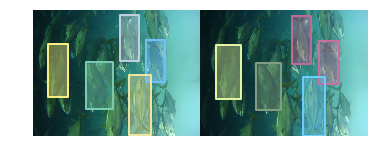

In [25]:
image = io.imread(image_directory + image_data['file_name'])
plt.imshow(image); plt.axis('off')
annotation_ids = example_coco.getAnnIds(imgIds=image_data['id'], catIds=category_ids, iscrowd=None)
annotations = example_coco.loadAnns(annotation_ids)
example_coco.showAnns(annotations)